In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import string
import re
import collections
from sklearn import preprocessing

%matplotlib inline

In [2]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# READ DATA 
train_df = pd.read_json('train.json.zip')
test_df = pd.read_json('test.json.zip')

# TRAIN DATA FEATURE ENGINEERING

In [4]:
# convert TARGET to the numeric
train_df['interest_level'] = train_df['interest_level'].apply(lambda x: 0 if x=='low' 
                                                      else 1 if x=='medium' 
                                                      else 2) 
# REMOVE UNNECESSARY WORDS FROM DESCRIPTION
train_df['description'] = train_df['description'].apply(lambda x: x.replace("<br />", ""))
train_df['description'] = train_df['description'].apply(lambda x: x.replace("br", ""))
train_df['description'] = train_df['description'].apply(lambda x: x.replace("<p><a", ""))

#basic features
train_df['rooms'] = train_df['bedrooms'] + train_df['bathrooms'] 

# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))

# description contains email
regex = r'[\w\.-]+@[\w\.-]+'
train_df['has_email'] = train_df['description'].apply(lambda x: 1 if re.findall(regex, x) else 0)

# description contains phone
train_df['has_phone'] = train_df['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)

# CONVERT LOWER ALL OF WORDS
train_df[["features"]] = train_df[["features"]].apply(
    lambda _: [list(map(str.strip, map(str.lower, x))) for x in _])

# TEST DATA FEATURE ENGINEERING

In [5]:
# REMOVE UNNECESSARY WORDS FROM DESCRIPTION
test_df['description'] = test_df['description'].apply(lambda x: x.replace("<br />", ""))
test_df['description'] = test_df['description'].apply(lambda x: x.replace("br", ""))
test_df['description'] = test_df['description'].apply(lambda x: x.replace("<p><a", ""))

#basic features
test_df['rooms'] = test_df['bedrooms'] + test_df['bathrooms'] 

# count of photos #
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# description contains email
regex = r'[\w\.-]+@[\w\.-]+'
test_df['has_email'] = test_df['description'].apply(lambda x: 1 if re.findall(regex, x) else 0)

# description contains phone
test_df['has_phone'] = test_df['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)

# CONVERT LOWER ALL OF WORDS
test_df[["features"]] = test_df[["features"]].apply(
    lambda _: [list(map(str.strip, map(str.lower, x))) for x in _])

# MOST FREQUENT FEATURES EXTRACTION

In [6]:
feature_value_train = train_df['features'].tolist()
feature_value_test = test_df['features'].tolist()

feature_value_train
feature_value_test

feature_lst_train = []
feature_lst_test = []

for i in range(len(feature_value_train)):
    feature_lst_train += feature_value_train[i]
    
for i in range(len(feature_value_test)):
    feature_lst_test += feature_value_test[i]

uniq_feature_train = list(set(feature_lst_train))
uniq_feature_test = list(set(feature_lst_test))


# see the frequency of each feature
def most_common(lst):
    features = collections.Counter(lst)
    feature_value = features.keys()
    frequency = features.values()
    data = [('feature_value', feature_value),
            ('frequency', frequency),]    
    df = pd.DataFrame.from_dict(dict(data))
    return df.sort_values(by = 'frequency', ascending = False)

df_features_train = most_common(feature_lst_train)
df_features_test = most_common(feature_lst_test)


def newColumn(name, df, series):
    feature = pd.Series(0,df.index,name = name)# data : 0
    for row,word in enumerate(series):
        if name in word:
            feature.iloc[row] = 1
    df[name] = feature # feature : series ; value in series : 1 or 0
    return df

# select features based on frequency
facilities = ['elevator', 'cats allowed', 'hardwood floors', 'dogs allowed', 'doorman', 'dishwasher', 'no fee', 'laundry in building', 'fitness center']
for name in facilities:
    train_df = newColumn(name, train_df, train_df['features'])
    test_df = newColumn(name, test_df, test_df['features'])

# LABEL ECONDING FOR CATEGORICAL VARIABLES

In [7]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))

### LOGARITHMIC EXPRESSION TO THE PRICE COLUMN

In [8]:
train_df['price'] = np.log10(train_df['price'])
test_df['price'] = np.log10(test_df['price'])

# DROP UNNECESSARY COLUMNS

In [9]:
# TRAINING DATASET
train_df.drop('created', axis=1, inplace=True)
train_df.drop('description', axis=1, inplace=True)
train_df.drop('features', axis=1, inplace=True)
train_df.drop('photos', axis=1, inplace=True)


# TEST DATASET
test_df.drop('created', axis=1, inplace=True)
test_df.drop('description', axis=1, inplace=True)
test_df.drop('features', axis=1, inplace=True)
test_df.drop('photos', axis=1, inplace=True)

# REGRESSION FOR PRICE

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import optuna
import math

X = train_df.drop(['price'], axis = 1)
y = train_df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .3,
                                                    random_state = 5)

In [11]:
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X, y)
        preds = model.predict(X_test)
        return mean_absolute_error(y_test, preds)
            
    def optimize(self):
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, n_trials=self.trials)
        return study

- XGB REGRESSOR OPTUNA PREDICTION

In [12]:
def create_model(trial):
    params = {
         'n_estimators': trial.suggest_int('n_estimators', 50, 300),
         'booster':trial.suggest_categorical('booster', ['gbtree', 'dart', 'gblinear']),
         'learning_rate':trial.suggest_loguniform("learning_rate", 0.001, 0.1),
         'max_depth':trial.suggest_int("max_depth", 3, 19),
         'subsample':trial.suggest_uniform("subsample", 0.0, 1.0),
         'colsample_bytree':trial.suggest_uniform("colsample_bytree", 0.0, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    return model

optimizer = Optimizer('mae')
xgb_opt_study = optimizer.optimize()
xgb_opt_params = xgb_opt_study.best_params
xgb_opt = xgb.XGBRegressor(**xgb_opt_params)   # Model
xgb_opt.fit(X, y)
preds = xgb_opt.predict(X_test)

print("Number of finished trials: ", len(xgb_opt_study.trials))
print("Best trial:")
xgb_trial = xgb_opt_study.best_trial

print("  Value: {}".format(xgb_trial.value))
print("  Params: ")
for key, value in xgb_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-09-28 18:16:31,160] A new study created in memory with name: no-name-4e4d1acb-627a-4a26-a46f-efe213208e3d


[18:16:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 18:16:33,597] Trial 0 finished with value: 0.20134641659672164 and parameters: {'n_estimators': 278, 'booster': 'gblinear', 'learning_rate': 0.010850385435729906, 'max_depth': 16, 'subsample': 0.5602141623432176, 'colsample_bytree': 0.3550977713232587}. Best is trial 0 with value: 0.20134641659672164.
[I 2021-09-28 18:16:35,576] Trial 1 finished with value: 2.2956628268885737 and parameters: {'n_estimators': 155, 'booster': 'gbtree', 'learning_rate': 0.0017626258456947554, 'max_depth': 13, 'subsample': 0.12389182216881356, 'colsample_bytree': 0.9802211044683887}. Best is trial 0 with value: 0.20134641659672164.


[18:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 18:16:35,872] Trial 2 finished with value: 0.15561609354979272 and parameters: {'n_estimators': 57, 'booster': 'gblinear', 'learning_rate': 0.09090937355395878, 'max_depth': 16, 'subsample': 0.08121130392713005, 'colsample_bytree': 0.14918326225588963}. Best is trial 2 with value: 0.15561609354979272.
[I 2021-09-28 18:18:00,390] Trial 3 finished with value: 0.3052427650754199 and parameters: {'n_estimators': 287, 'booster': 'dart', 'learning_rate': 0.007958719630581626, 'max_depth': 18, 'subsample': 0.8765308177857986, 'colsample_bytree': 0.9317730625597962}. Best is trial 2 with value: 0.15561609354979272.


[18:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 18:18:01,239] Trial 4 finished with value: 0.40488819871813514 and parameters: {'n_estimators': 178, 'booster': 'gblinear', 'learning_rate': 0.0026085547937412775, 'max_depth': 14, 'subsample': 0.49805551421137795, 'colsample_bytree': 0.17339968259869198}. Best is trial 2 with value: 0.15561609354979272.


[18:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 18:18:02,139] Trial 5 finished with value: 0.13816810202554713 and parameters: {'n_estimators': 201, 'booster': 'gblinear', 'learning_rate': 0.038794947732943376, 'max_depth': 8, 'subsample': 0.35475333088057637, 'colsample_bytree': 0.2565025039121238}. Best is trial 5 with value: 0.13816810202554713.


[18:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 18:18:02,490] Trial 6 finished with value: 0.4834928994833425 and parameters: {'n_estimators': 62, 'booster': 'gblinear', 'learning_rate': 0.004220197733275148, 'max_depth': 11, 'subsample': 0.6216350798688095, 'colsample_bytree': 0.9984109085549255}. Best is trial 5 with value: 0.13816810202554713.
[I 2021-09-28 18:18:43,808] Trial 7 finished with value: 0.11297685221950249 and parameters: {'n_estimators': 217, 'booster': 'dart', 'learning_rate': 0.015151791535627462, 'max_depth': 5, 'subsample': 0.5160642108567114, 'colsample_bytree': 0.8630406604673362}. Best is trial 7 with value: 0.11297685221950249.
[I 2021-09-28 18:19:36,483] Trial 8 finished with value: 0.587421074343272 and parameters: {'n_estimators': 283, 'booster': 'dart', 'learning_rate': 0.00576649424669692, 'max_depth': 10, 'subsample': 0.22941534976802191, 'colsample_bytree': 0.039485032651099816}. Best is trial 7 with value: 0.11297685221950249.
[I 2021-09-28 18:19:59,349] Trial 9 finished with value: 0.3

Number of finished trials:  30
Best trial:
  Value: 0.011530626244851312
  Params: 
    n_estimators: 258
    booster: gbtree
    learning_rate: 0.04059823671520865
    max_depth: 15
    subsample: 0.917745748048933
    colsample_bytree: 0.804284637877227


- RANDOM FOREST OPTUNA PREDICTION

In [13]:
def create_model(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth',3 ,19),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])
    }
    model = RandomForestRegressor(**params)
    return model

optimizer = Optimizer('mae')
rf_opt_study = optimizer.optimize()
rf_opt_params = rf_opt_study.best_params
rf_opt = RandomForestRegressor(**rf_opt_params)
rf_opt.fit(X, y)
preds = rf_opt.predict(X_test)

print("Number of finished trials: ", len(rf_opt_study.trials))
print("Best trial:")
rf_trial = rf_opt_study.best_trial

print("  Value: {}".format(rf_trial.value))
print("  Params: ")
for key, value in rf_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-09-28 18:23:43,132] A new study created in memory with name: no-name-725abcb7-f8b2-48e1-9cfd-a4a151f1f2fb
[I 2021-09-28 18:24:03,182] Trial 0 finished with value: 0.04507073876475043 and parameters: {'n_estimators': 225, 'max_depth': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.04507073876475043.
[I 2021-09-28 18:24:09,884] Trial 1 finished with value: 0.06796315399765382 and parameters: {'n_estimators': 137, 'max_depth': 7, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.04507073876475043.
[I 2021-09-28 18:24:21,458] Trial 2 finished with value: 0.0451363711803877 and parameters: {'n_estimators': 129, 'max_depth': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.04507073876475043.
[I 2021-09-28 18:24:28,186] Trial 3 finished with value: 0.04327169272641093 and parameters: {'n_estimators': 74, 'max_depth': 16, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with 

Number of finished trials:  30
Best trial:
  Value: 0.02183871966090859
  Params: 
    n_estimators: 116
    max_depth: 19
    min_samples_leaf: 1
    max_features: auto


- LINEAR REGRESSION OPTUNA PREDICTION

In [15]:
def create_model(trial):
    params = {
        'copy_X': trial.suggest_categorical("copy_X", ["True", "False"]),
        'fit_intercept': trial.suggest_categorical("fit_intercept", ["True", "False"]),
        'n_jobs': trial.suggest_int('n_jobs',-1 ,3),
    }
    model = LinearRegression(**params)
    return model

optimizer = Optimizer('mae')
lr_opt_study = optimizer.optimize()
lr_opt_params = lr_opt_study.best_params
lr_opt = LinearRegression(**lr_opt_params)
lr_opt.fit(X, y)
preds = lr_opt.predict(X_test)

print("Number of finished trials: ", len(lr_opt_study.trials))
print("Best trial:")
lr_trial = lr_opt_study.best_trial

print("  Value: {}".format(lr_trial.value))
print("  Params: ")
for key, value in lr_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-09-28 18:51:22,470] A new study created in memory with name: no-name-c274156e-4c6c-4aa0-8a81-782de0c30417
[I 2021-09-28 18:51:22,532] Trial 0 finished with value: 0.08446668127102264 and parameters: {'copy_X': 'False', 'fit_intercept': 'True', 'n_jobs': 2}. Best is trial 0 with value: 0.08446668127102264.
[I 2021-09-28 18:51:22,580] Trial 1 finished with value: 0.08446668127102264 and parameters: {'copy_X': 'True', 'fit_intercept': 'False', 'n_jobs': 2}. Best is trial 0 with value: 0.08446668127102264.
[I 2021-09-28 18:51:22,629] Trial 2 finished with value: 0.08446668127102264 and parameters: {'copy_X': 'True', 'fit_intercept': 'False', 'n_jobs': -1}. Best is trial 0 with value: 0.08446668127102264.
[I 2021-09-28 18:51:22,679] Trial 3 finished with value: 0.08446668127102264 and parameters: {'copy_X': 'True', 'fit_intercept': 'False', 'n_jobs': 1}. Best is trial 0 with value: 0.08446668127102264.
[I 2021-09-28 18:51:22,727] Trial 4 finished with value: 0.08446668127102264 and 

Number of finished trials:  30
Best trial:
  Value: 0.08446668127102264
  Params: 
    copy_X: False
    fit_intercept: True
    n_jobs: 2


Let me show description of price

In [16]:
train_df['price'].describe()

count    49352.000000
mean         3.517365
std          0.187979
min          1.633468
25%          3.397940
50%          3.498311
75%          3.612784
max          6.652246
Name: price, dtype: float64

* Pipeline for storing models

In [17]:
pipeline_models = []

xgb_default = xgb.XGBRegressor()
rf_default = RandomForestRegressor()
lr_default = LinearRegression()
svm_default = SVR()

models = [xgb_default, xgb_opt,
          rf_default, rf_opt,
          lr_default, lr_opt,
          svm_default]

model_names = ['XGB Regression (default)', 'XGB Regression (opt)', 
               'Random Forest (default)', 'Random Forest (opt)',
               'Linear Regression (default)', 'Linear Regression (opt)',
               'Support Vector Machine (default)']

## Assign each model to a pipeline
for name, model in zip(model_names,models):
    pipeline = ("Scaled_"+ name,
                Pipeline([("Scaler",StandardScaler()),
                          (name,model)
                         ]))
    pipeline_models.append(pipeline)

* Evaluate scores

* BEFORE PREDICTION INVERSE LOG10

In [18]:
train_df['price'] = 10 ** train_df['price']
test_df['price'] = 10 ** test_df['price']

In [19]:
train_df['price']

4         2400.0
6         3800.0
9         3495.0
10        3000.0
15        2795.0
           ...  
124000    2800.0
124002    2395.0
124004    1850.0
124008    4195.0
124009    4280.0
Name: price, Length: 49352, dtype: float64

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate

## Create a dataframe to store all the models' cross validation score
evaluate = pd.DataFrame(columns=["model","cv_MAE", "cv_RMSE"])
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Encoded dataset
for name,model in pipeline_models:
    scores = cross_validate(model, X, y, cv=kfold, n_jobs=-1,
                         scoring=('neg_root_mean_squared_error', 'neg_mean_absolute_error'))
    
    row = evaluate.shape[0]
    evaluate.loc[row,"model"] = name
    evaluate.loc[row,"cv_MAE"] = round(abs(scores['test_neg_mean_absolute_error']).mean(), 3)
    evaluate.loc[row,"cv_RMSE"] = round(abs(scores['test_neg_root_mean_squared_error']).mean(), 3)

In [21]:
evaluate

,model,cv_MAE,cv_RMSE
0,Scaled_XGB Regression (default),746.231,17043.802
1,Scaled_XGB Regression (opt),616.097,17431.662
2,Scaled_Random Forest (default),683.183,17333.613
3,Scaled_Random Forest (opt),698.806,17190.847
4,Scaled_Linear Regression (default),1182.765,16114.983
5,Scaled_Linear Regression (opt),1182.765,16114.983
6,Scaled_Support Vector Machine (default),1122.515,16241.87


- MAE score visualization

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Scaled_XGB Regression (default)'),
 Text(1, 0, 'Scaled_XGB Regression (opt)'),
 Text(2, 0, 'Scaled_Random Forest (default)'),
 Text(3, 0, 'Scaled_Random Forest (opt)'),
 Text(4, 0, 'Scaled_Linear Regression (default)'),
 Text(5, 0, 'Scaled_Linear Regression (opt)'),
 Text(6, 0, 'Scaled_Support Vector Machine (default)')]

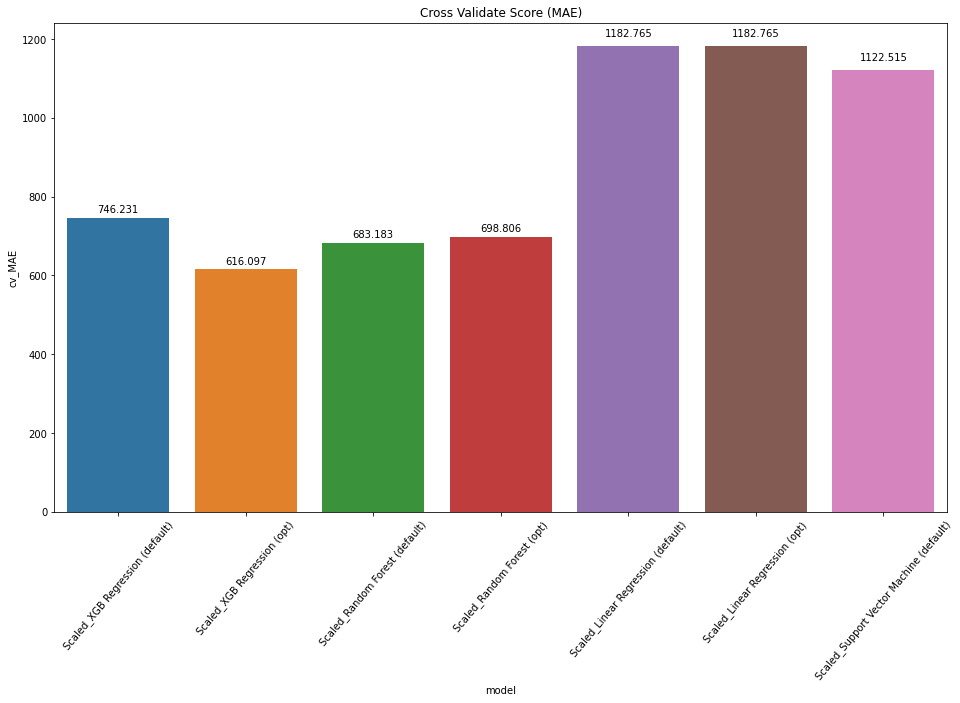

In [22]:
## Visualization
fig, ax = plt.subplots(figsize=(16,9))

## Encoded dataset
bar = sns.barplot(evaluate["model"], evaluate["cv_MAE"])
for rec in bar.patches:
    height = rec.get_height()
    ax.text(rec.get_x() + rec.get_width()/2, height*1.02,height,ha="center")
ax.set_title("Cross Validate Score (MAE)")
ax.set_xticklabels(evaluate["model"].to_list(),rotation =50)

- RMSE score visualization

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Scaled_XGB Regression (default)'),
 Text(1, 0, 'Scaled_XGB Regression (opt)'),
 Text(2, 0, 'Scaled_Random Forest (default)'),
 Text(3, 0, 'Scaled_Random Forest (opt)'),
 Text(4, 0, 'Scaled_Linear Regression (default)'),
 Text(5, 0, 'Scaled_Linear Regression (opt)'),
 Text(6, 0, 'Scaled_Support Vector Machine (default)')]

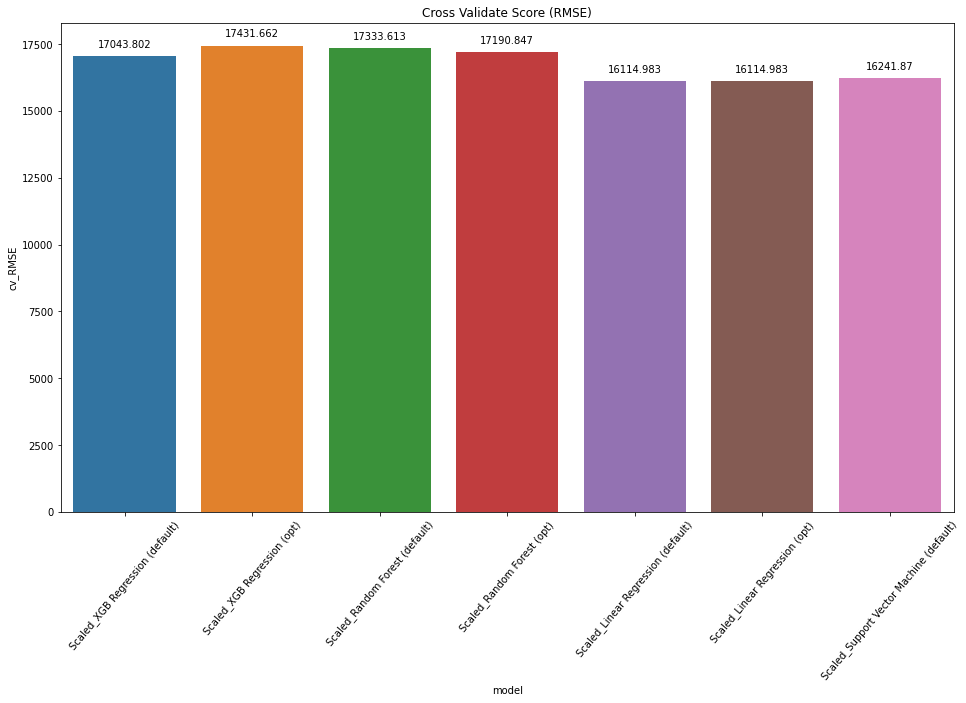

In [23]:
## Visualization
fig, ax = plt.subplots(figsize=(16,9))

## Encoded dataset
bar = sns.barplot(evaluate["model"], evaluate["cv_RMSE"])
for rec in bar.patches:
    height = rec.get_height()
    ax.text(rec.get_x() + rec.get_width()/2, height*1.02,height,ha="center")
ax.set_title("Cross Validate Score (RMSE)")
ax.set_xticklabels(evaluate["model"].to_list(),rotation =50)